# Setup

In [1]:
# SETUP
!pip install pystan
!pip install wurlitzer

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Data load

### Mental rotation dataset
https://openpsychologydata.metajnl.com/articles/10.5334/jopd.ai/

These are data collected in a psychology experiment aiming to validate a stimulus dataset.

You can read the full description of data collection at the above link.

The task was to tell whether the two objects simultaneously presented in a trial (see example image) were the same or reflected.

48 participants, 96 trials each, 96 different conditions in total. Reaction times collected in msec and whether the responses were correct or incorrect.
![alt text](https://www.kfki.hu/~tbalazs/teaching/examples/mental_rotation/stimuli_jpg/1_50.jpg)

In [1]:
import pandas
df = pandas.read_csv('https://kfki.hu/~tbalazs/teaching/examples/mental_rotation/mental_rotation_behavioural_data.csv',
                     header = 0)
image_codes = pandas.read_csv('https://kfki.hu/~tbalazs/teaching/examples/mental_rotation/image_codes.csv',
                     header = 0,
                     skiprows = [1])
image_codes = image_codes.rename(columns={"Cube sequence": "condition_name", "Filename": "base_file"})

In [2]:
from IPython.display import display
display(df[0:5])
display(image_codes[0:5])

Trial            Condition    Time response correct  angle  \
0      1     R2_3_3_2_0Y0.pct  1355.0      [n]     [n]      0   
1      2  R3_4_3_2_90Y150.pct  2079.0      [n]     [n]    150   
2      3    2_4_4_2_0Y150.pct  1834.0      [b]     [b]    150   
3      4    3_3_3_2_0Y100.pct  4780.0      [b]     [b]    100   
4      5    3_3_3_3_90Y50.pct  1685.0      [b]     [b]     50   

   correct/incorrect  Subject  
0                  1        1  
1                  1        1  
2                  1        1  
3                  1        1  
4                  1        1

condition_name base_file
0      2_3_3_2_A     1.jpg
1      2_3_3_2_B     2.jpg
2      2_3_3_2_C     3.jpg
3      2_3_3_3_A     4.jpg
4      2_3_3_3_B     5.jpg

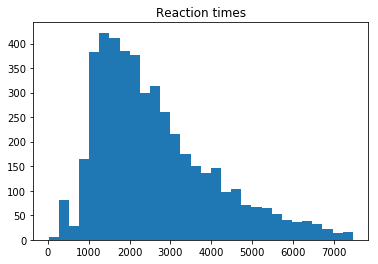

In [3]:
df = df.fillna(500) # THIS IS NOT PRINCIPLED ACTUALLY

import matplotlib.pyplot as plt
plt.hist(df.Time,30)
plt.title('Reaction times')
plt.show()

In [4]:
import numpy as np
conditions = df.Condition.unique()
def get_cond_id(condition):
  return(np.where(conditions == condition)[0][0])
df['cond_id'] = df.Condition.apply(get_cond_id)

# Stan model

We define the following model:

Participants have skills, that are scalars for each participant: 

In [5]:
stan_code = """
data{
  int<lower=1> N_subject;
  int<lower=1> N_trial;
  int<lower=1> N_condition;
  int<lower=0, upper=1> correct[N_subject,N_trial];
  real<lower=0.0> rt[N_subject,N_trial];
  int<lower=0> condition[N_subject,N_trial];
}

transformed data{
  real<lower=0.0> inv_rt[N_subject, N_trial];
  for (s in 1:N_subject){
    for (t in 1:N_trial){
      inv_rt[s,t] = 1 / rt[s,t];
    }
  }
}

parameters{
  real skill[N_subject];
  real difficulty[N_condition];
  real<upper=0.0> beta_rt;
  real<lower=0.0> sigma_rt;
}

model{
  difficulty ~ normal(0,1);
  sigma_rt ~ gamma(1,1);
  skill ~ normal(0,1);

  for (s in 1:N_subject){
    for (t in 1:N_trial){
      correct[s,t] ~ bernoulli(inv_logit(skill[s]-difficulty[condition[s,t]]));
      inv_rt[s,t] ~ normal(beta_rt*inv_logit(skill[s]-difficulty[condition[s,t]]),sigma_rt);
    }
  }
}
"""

In [11]:
from pystan import StanModel
sm = StanModel(model_code = stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba8f3f48a8694ee2f840138576ee6b21 NOW.


In [12]:
N_subject = max(df.Subject)
correct = df['correct/incorrect'].reshape((N_subject,int(df.count()[0]/N_subject)))
cond_id = df['cond_id'].reshape((N_subject,int(df.count()[0]/N_subject)))
rt = df['Time'].reshape((N_subject,int(df.count()[0]/N_subject)))

stan_data = dict(N_subject = max(df.Subject),
                 N_condition = max(df.cond_id)+1,
                 N_trial = max(df.Trial),
                 correct = correct,
                 condition = cond_id+1,
                 rt = rt)

/Users/karaj/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/karaj/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Users/karaj/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [13]:
from wurlitzer import sys_pipes 
# Ez abban segít, hogy a stan futása közben kapjunk infot a progress-ről.
with sys_pipes():
  fit = sm.sampling(data = stan_data,
                    chains = 2,
                    iter = 300)

/Users/karaj/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 35)

If this warning occurs sporadically,


Gradient evaluation took 0.00253 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.3 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002424 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.24 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 210 / 300 [ 70%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 240 /

### Posteriors

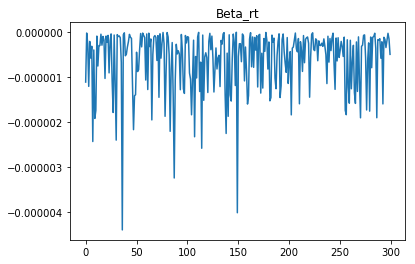

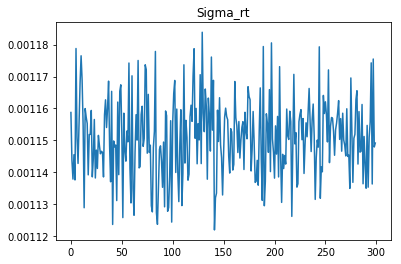

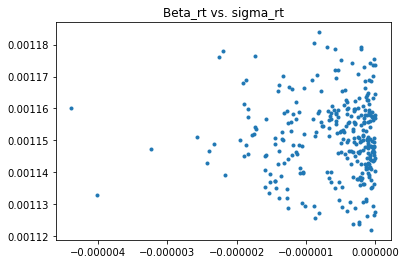

In [14]:
samples = fit.extract()
plt.plot(samples['beta_rt'])
plt.title('Beta_rt')
plt.show()

plt.plot(samples['sigma_rt'])
plt.title('Sigma_rt')
plt.show()

plt.plot(samples['beta_rt'], samples['sigma_rt'],'.')
plt.title('Beta_rt vs. sigma_rt')
plt.show()


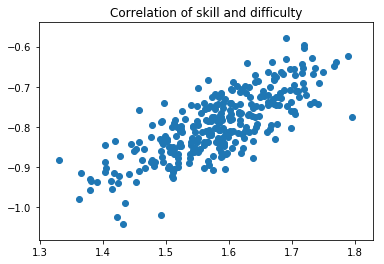

In [15]:
import matplotlib.pyplot as plt
plt.scatter([np.mean(skill) for skill in samples['skill']],
         [np.mean(difficulty) for difficulty in samples['difficulty']])
plt.title('Correlation of skill and difficulty')
plt.show()

### Functions for obtaining stimulus image names

In [16]:
import pandas as pd
result = pd.DataFrame(dict(difficulty = np.mean(samples['difficulty'],0),
                           condition = conditions))
def extract_condition_name(condition):
  code = condition.split('.')[0].split('R')[-1]
  angle = code.split('Y')[-1]
  code = code.split('Y')[0]
  if (code[8:] == '0'):
    return(code[:7]+'_A')
  if (code[8:] == '90'):
    return(code[:7]+'_B')
  if (code[8:] == '180'):
    return(code[:7]+'_C')
  return(code)

def extract_condition_angle(condition):
  return(condition.split('.')[0].split('Y')[-1])

def extract_reflected(condition):
  if(condition[0]=='R'):
    return('R')
  else:
    return('')

def get_file_name(row):
  filename = row['base_file'].split('.')[0]
  filename += '_'+row['angle']
  if (row['reflected'] == 'R'):
    filename += '_R'
  filename += '.jpg'
  return(filename)
  
result['condition_name'] = result.condition.apply(extract_condition_name)
result['angle'] = result.condition.apply(extract_condition_angle)
result['reflected'] = result.condition.apply(extract_reflected)
result = pd.merge(result, image_codes)
result['filename'] = result.apply(get_file_name, axis = 1)
#display(result)

### Condition posterior difficulties

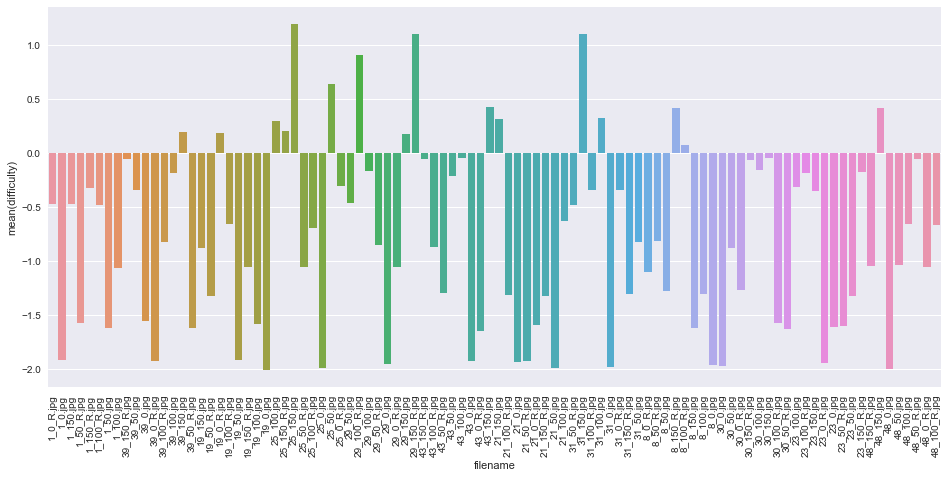

In [17]:
import seaborn
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 7
g = seaborn.barplot(data = result, x = 'filename', y = 'difficulty')
plt.xticks(rotation=90)
plt.show()

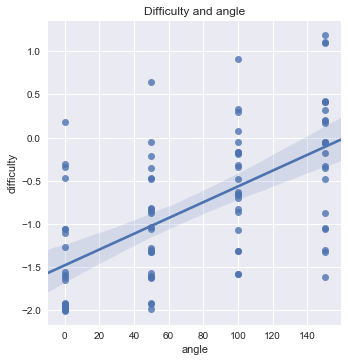

In [18]:
result['angle'] = pd.to_numeric(result['angle'])
seaborn.lmplot(data = result, x = 'angle', y = 'difficulty')
plt.title('Difficulty and angle')
plt.show()

### Stimulus examples
1. Easy stimuli
2. Medium difficulty stimuli
3. Hard stimuli

In [19]:
# EASY ONES
from IPython.display import Image
PATH = 'https://kfki.hu/~tbalazs/teaching/examples/mental_rotation/stimuli_jpg/'
for filename in result[result.difficulty<-1.95].filename:
    display(Image(url = PATH+filename, width=300, height=150))

In [20]:
# Medium
from IPython.display import Image
PATH = 'https://kfki.hu/~tbalazs/teaching/examples/mental_rotation/stimuli_jpg/'
for filename in result[(result.difficulty>0.3)][(result.difficulty<0.5)].filename:
    display(Image(url = PATH+filename, width=300, height=150))

/Users/karaj/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [21]:
# HARD ONES
from IPython.display import Image
PATH = 'https://kfki.hu/~tbalazs/teaching/examples/mental_rotation/stimuli_jpg/'
for filename in result[result.difficulty>1.0].filename:
  display(Image(url = PATH+filename, width=300, height=150))